In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-marketing-dataset/bank-full.csv


### Load the packages

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
import graphviz
%matplotlib inline

### Load the data

In [5]:
df = pd.read_csv('../input/bank-marketing-dataset/bank-full.csv', sep=",")


In [6]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [7]:
df['conversion'] = df['y'].apply(lambda x: 0 if x == 'no' else 1)

### Data Analysis

**Conversion Rate**

In [8]:

conversion_rate_df = pd.DataFrame(
    df.groupby('conversion').count()['y'] / df.shape[0] * 100.0
)

In [9]:
conversion_rate_df.T

conversion,0,1
y,88.30152,11.69848


**Conversion Rates by Marital Status**

In [10]:
conversion_rate_by_marital = df.groupby(
    by='marital'
)['conversion'].sum() / df.groupby(
    by='marital'
)['conversion'].count() * 100.0

In [11]:
conversion_rate_by_marital


marital
divorced    11.945458
married     10.123466
single      14.949179
Name: conversion, dtype: float64

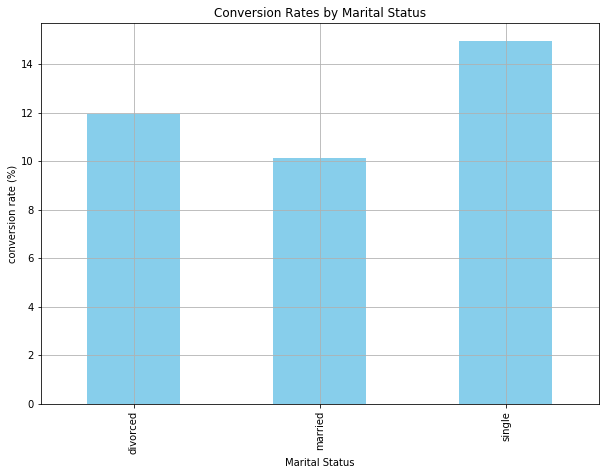

In [12]:
ax = conversion_rate_by_marital.plot(
    kind='bar',
    color='skyblue',
    grid=True,
    figsize=(10, 7),
    title='Conversion Rates by Marital Status'
)

ax.set_xlabel('Marital Status')
ax.set_ylabel('conversion rate (%)')

plt.show()

**Conversion Rates by Job**

In [13]:
conversion_rate_by_job = df.groupby(
    by='job'
)['conversion'].sum() / df.groupby(
    by='job'
)['conversion'].count() * 100.0

In [14]:
conversion_rate_by_job


job
admin.           12.202669
blue-collar       7.274969
entrepreneur      8.271688
housemaid         8.790323
management       13.755551
retired          22.791519
self-employed    11.842939
services          8.883004
student          28.678038
technician       11.056996
unemployed       15.502686
unknown          11.805556
Name: conversion, dtype: float64

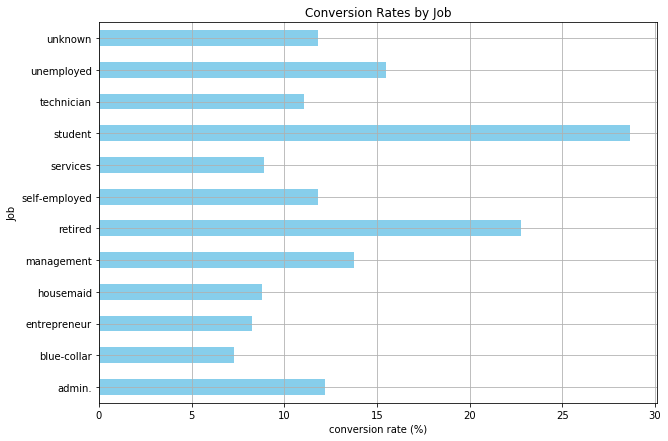

In [15]:

ax = conversion_rate_by_job.plot(
    kind='barh',
    color='skyblue',
    grid=True,
    figsize=(10, 7),
    title='Conversion Rates by Job'
)

ax.set_xlabel('conversion rate (%)')
ax.set_ylabel('Job')

plt.show()

**Default Rates by Conversions**

In [16]:
default_by_conversion_df = pd.pivot_table(
    df, 
    values='y', 
    index='default', 
    columns='conversion', 
    aggfunc=len
)
default_by_conversion_df.columns = ['non_conversions', 'conversions']

In [17]:
default_by_conversion_df

,non_conversions,conversions
default,,
no,39159,5237
yes,763,52


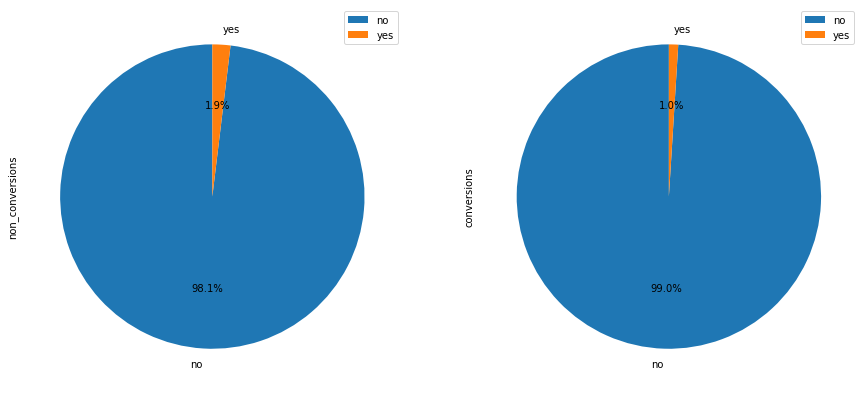

In [18]:
default_by_conversion_df.plot(
    kind='pie',
    figsize=(15, 7),
    startangle=90,
    subplots=True,
    autopct=lambda x: '%0.1f%%' % x
)

plt.show()

**Bank Balance by Conversions**

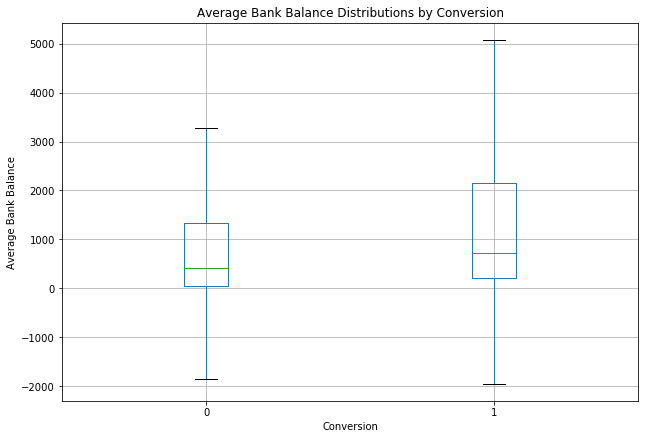

In [19]:
ax = df[['conversion', 'balance']].boxplot(
    by='conversion',
    showfliers=False,
    figsize=(10, 7)
)

ax.set_xlabel('Conversion')
ax.set_ylabel('Average Bank Balance')
ax.set_title('Average Bank Balance Distributions by Conversion')

plt.suptitle("")
plt.show()

**Conversions by Number of Contacts**

In [20]:
conversions_by_num_contacts = df.groupby(
    by='campaign'
)['conversion'].sum() / df.groupby(
    by='campaign'
)['conversion'].count() * 100.0

In [21]:
pd.DataFrame(conversions_by_num_contacts).head()

,conversion
campaign,
1,14.597583
2,11.203519
3,11.193624
4,9.000568
5,7.879819


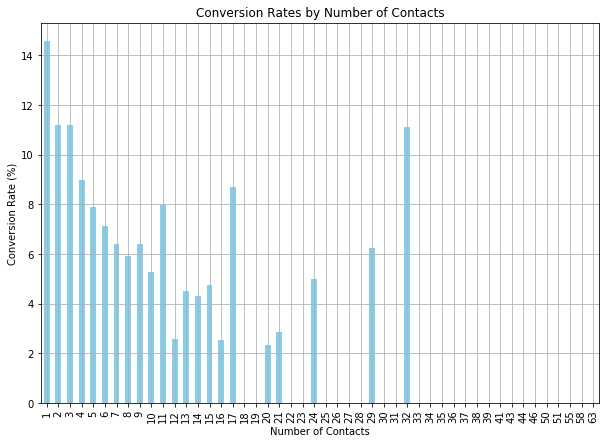

In [22]:
ax = conversions_by_num_contacts.plot(
    kind='bar',
    figsize=(10, 7),
    title='Conversion Rates by Number of Contacts',
    grid=True,
    color='skyblue'
)

ax.set_xlabel('Number of Contacts')
ax.set_ylabel('Conversion Rate (%)')

plt.show()

### Encoding Categorical Variables

In [23]:
categorical_vars = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month'
]

In [24]:
df[categorical_vars].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
dtype: int64

**encoding 'month‘**

In [25]:
df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [26]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['month'] = df['month'].apply(
    lambda x: months.index(x)+1
)

In [27]:
df['month'].unique()

array([ 5,  6,  7,  8, 10, 11, 12,  1,  2,  3,  4,  9])

In [28]:
df.groupby('month').count()['conversion']

month
1      1403
2      2649
3       477
4      2932
5     13766
6      5341
7      6895
8      6247
9       579
10      738
11     3970
12      214
Name: conversion, dtype: int64

**encoding 'job'**

In [29]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [30]:
jobs_encoded_df = pd.get_dummies(df['job'])

In [31]:
jobs_encoded_df.head(3)

,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0


In [32]:
jobs_encoded_df.columns = ['job_%s' % x for x in jobs_encoded_df.columns]
jobs_encoded_df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1


In [33]:
df = pd.concat([df, jobs_encoded_df], axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,0,0,1,0,0,0,0,0,0,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,0,0,0,0,0,0,0,1,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,0,0,0,0,0,0,0,0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,0,0,0,0,0,0,0,0,0,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,0,0,0,0,0,0,0,0,0,1


**encoding 'marital'**

In [34]:
marital_encoded_df = pd.get_dummies(df['marital'])
marital_encoded_df.columns = ['marital_%s' % x for x in marital_encoded_df.columns]

In [35]:
df = pd.concat([df, marital_encoded_df], axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,0,0,0,0,0,0,0,0,1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,0,0,0,0,1,0,0,0,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,0,0,0,0,0,0,0,0,1,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,0,0,0,0,0,0,0,0,1,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,0,0,0,0,0,0,1,0,0,1


**encoding 'housing’**

In [36]:
df['housing'].unique()
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)

**encoding 'loan‘**

In [37]:
df['loan'].unique()
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

### Fitting Decision Trees

In [38]:
features = [
    'age',
    'balance',
    'campaign',
    'previous',
    'housing',
] + list(jobs_encoded_df.columns) + list(marital_encoded_df.columns)

response_var = 'conversion'

In [39]:
features

['age',
 'balance',
 'campaign',
 'previous',
 'housing',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single']

In [41]:
dt_model = tree.DecisionTreeClassifier(
    max_depth=4
)

In [42]:
dt_model.fit(df[features], df[response_var])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Interpreting Decision Tree Model

In [43]:
dot_data = tree.export_graphviz(
    dt_model, 
    out_file=None, 
    feature_names=features,  
    class_names=['0', '1'],  
    filled=True, 
    rounded=True,  
    special_characters=True
)

In [ ]:
graph = graphviz.Source(dot_data)
from IPython.core.display import display, HTML
display(HTML("<style>text {font-size: 10px;}</style>"))

graph